# Pytorch: nn Module

The `torch.tensor` is just a small part of `pytorch`.  The main contribution of the `pytorch` package is its `nn` module that is used to construct and train many kinds of neural networks.

Here we apply it to the two problems, one regression and one classification problem.

In [1]:
import numpy as np
import pandas
import torch

import time

import matplotlib.pyplot as plt
%matplotlib inline

## Regression

Load data for the air quality regression problem. `torch.nn` expects data to be `float32`.

In [2]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]
data = data [:23*10]
data = data.dropna(axis=0)

hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1).astype(np.float32)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1).astype(np.float32)
np.hstack((X, T))[:10]  # show the first 10 samples of hour, CO

array([[18. ,  2.6],
       [19. ,  2. ],
       [20. ,  2.2],
       [21. ,  2.2],
       [22. ,  1.6],
       [23. ,  1.2],
       [ 0. ,  1.2],
       [ 1. ,  1. ],
       [ 2. ,  0.9],
       [ 3. ,  0.6]], dtype=float32)

Since we are using `torch`, we must convert our data matrices, `X` and `T`, to `torch.tensors`.

Must standardize data ourselves.

In [3]:
Xmean = X.mean()
Xstd = X.std()
Tmean = T.mean()
Tstd = T.std()

X = (X - Xmean) / Xstd
T = (T - Tmean) / Tstd

In [4]:
Xt = torch.tensor(X)
Tt = torch.tensor(T)

In [5]:
n_inputs = Xt.shape[1]
n_hiddens = 10
n_outputs = Tt.shape[1]

Create the network.

In [6]:
nnet = torch.nn.Sequential(
    torch.nn.Linear(n_inputs, n_hiddens),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hiddens, n_outputs))

Specify the loss function and the optimizer method.

In [7]:
loss_F = torch.nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

Now we can train it.

In [8]:
for epoch in range(10000):
    Yt = nnet(Xt)
    
    error = loss_F(Yt, Tt)
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} error {error}')
        
    error.backward()
    
    optimizer.step()

Epoch 0 error 1.0500296354293823
Epoch 1000 error 0.7617560625076294
Epoch 2000 error 0.8109873533248901
Epoch 3000 error 0.7493433356285095
Epoch 4000 error 0.7848597168922424
Epoch 5000 error 0.7346455454826355
Epoch 6000 error 0.743979275226593
Epoch 7000 error 0.7343453168869019
Epoch 8000 error 0.7223423719406128
Epoch 9000 error 0.7094852328300476


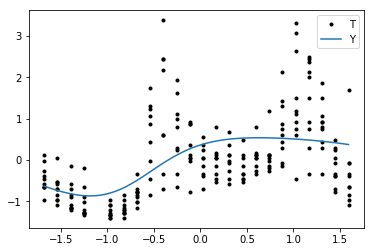

In [9]:
xs = np.linspace(0, 23, 100).reshape((-1, 1)).astype(np.float32)
xs = (xs - Xmean) / Xstd
xst = torch.tensor(xs)
Yt = nnet(xst)
plt.plot(Xt, Tt, 'k.', label='T')
plt.plot(xs, Yt.detach(), label='Y')
plt.legend();

Here is all the code together in one block. It assumes the data has been defined.

Epoch 0 error 0.9788386821746826
Epoch 200 error 0.6859443187713623
Epoch 400 error 0.3973020911216736
Epoch 600 error 0.36954018473625183
Epoch 800 error 0.3645980954170227
Epoch 1000 error 0.36275145411491394
Epoch 1200 error 0.36197489500045776
Epoch 1400 error 0.3613126277923584
Epoch 1600 error 0.36106911301612854
Epoch 1800 error 0.360820472240448


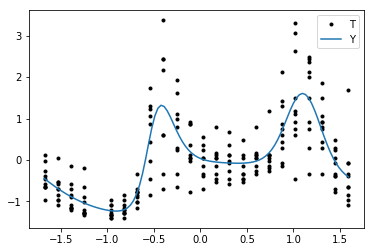

In [10]:
Xt = torch.tensor(X)
Tt = torch.tensor(T)

Xtmean = Xt.mean()
Xtstd = Xt.std()
Ttmean = Tt.mean()
Ttstd = Tt.std()

Xt = (Xt - Xtmean) / Xtstd
Tt = (Tt - Ttmean) / Ttstd

n_inputs = Xt.shape[1]
n_hiddens = 20
n_outputs = Tt.shape[1]

nnet = torch.nn.Sequential(
    torch.nn.Linear(n_inputs, n_hiddens),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hiddens, n_outputs))

loss_F = torch.nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

for epoch in range(2000):
    
    optimizer.zero_grad()
        
    Yt = nnet(Xt)
    
    error = loss_F(Yt, Tt)
    if epoch % 200 == 0:
        print(f'Epoch {epoch} error {error}')
        
    error.backward()
    
    optimizer.step()

xs = np.linspace(0, 23, 100).reshape((-1, 1)).astype(np.float32)
xs = (xs - Xmean) / Xstd
xst = torch.tensor(xs)
Yt = nnet(xst)
plt.plot(Xt, Tt, 'k.', label='T')
plt.plot(xs, Yt.detach(), label='Y')
plt.legend();

# Classification

Let's make some simple images of two different types to test the `torch.nn` module way of doing classification.

One type of image with be a diamond shape at various positions.  The other type will be a square.

In [11]:
def make_images(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.float32)

Xtrain, Ttrain = make_images(100)
Xtest, Ttest = make_images(10)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((200, 1, 20, 20), (200, 1), (20, 1, 20, 20), (20, 1))

In [12]:
Ttest

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]], dtype=float32)

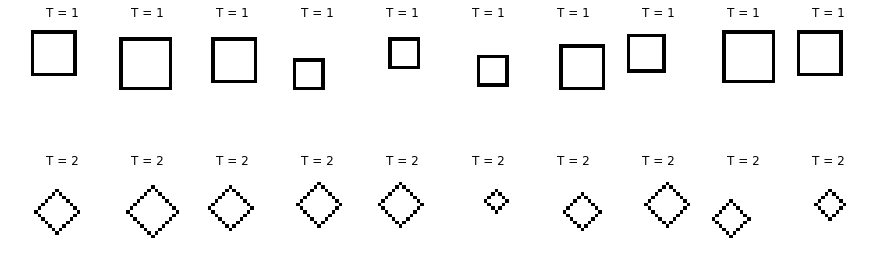

In [13]:
plt.figure(figsize=(15, 5))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(Xtest[i, 0, :, :], cmap=plt.cm.binary)
    plt.title(f'T = {int(Ttest[i, 0])}')
    plt.axis('off');

To send these images as input into a neural network, each image must be flattened.  In this case, each image will be 20 x 20 or 400 pixel intensities.

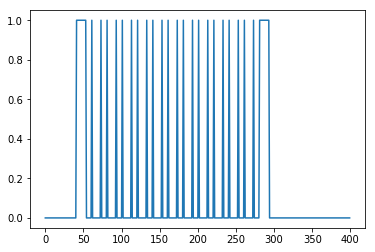

In [14]:
plt.plot(Xtest[0, 0, :, :].reshape((-1)))

In [15]:
Xtrain_flat = Xtrain.reshape((-1, 400))
Xtrain_flat.shape

(200, 400)

In [16]:
Xtest_flat = Xtest.reshape((-1, 400))
Xtest_flat.shape

(20, 400)

In [17]:
classes = np.unique(Ttrain)
classes

array([1., 2.], dtype=float32)

In [18]:
_, Ttrain_0 = np.where(Ttrain == classes)
_, Ttest_0 = np.where(Ttest == classes)
Ttest_0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

Epoch 0 error 0.71539
Epoch 50 error 0.00115
Epoch 100 error 0.00039
Epoch 150 error 0.00026
16 out of 20 test samples correctly classified.


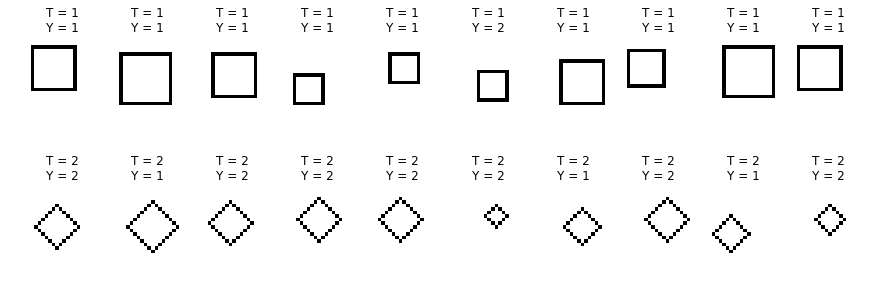

In [19]:
classes = np.unique(Ttrain)
_, Ttrain_0 = np.where(Ttrain == classes)
_, Ttest_0 = np.where(Ttest == classes)

Xtraint = torch.tensor(Xtrain_flat)
Ttraint = torch.tensor(Ttrain_0)
Xtestt = torch.tensor(Xtest_flat)
Ttestt = torch.tensor(Ttest_0)

Xtmean = Xtraint.mean(0)
Xtstd = Xtraint.std(0)

if False:
    Xtraint = (Xtraint - Xtmean) / Xtstd
    Xtestt = (Xtestt - Xtmean) / Xtstd

n_inputs = Xtraint.shape[1]
n_hiddens = 20
n_outputs = len(classes)

nnet = torch.nn.Sequential(
    torch.nn.Linear(n_inputs, n_hiddens),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hiddens, n_outputs))

loss_F = torch.nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

for epoch in range(200):
    
    optimizer.zero_grad()
    
    Ytraint = nnet(Xtraint)
    
    error = loss_F(Ytraint, Ttraint)
    if epoch % 50 == 0:
        print(f'Epoch {epoch} error {error:.5f}')
        
    error.backward()
    
    optimizer.step()

Ytestt = nnet(Xtestt)
Ytest = Ytestt.detach().numpy()
Ytestclasses = classes[Ytest.argmax(axis=1)].reshape((-1, 1))
plt.figure(figsize=(15, 5))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(Xtest[i, 0, :, :], cmap=plt.cm.binary)
    plt.title(f'T = {int(Ttest[i, 0])}\nY = {int(Ytestclasses[i])}')
    plt.axis('off')
    
print(f'{np.sum(Ttest == Ytestclasses)} out of {Ttest.shape[0]} test samples correctly classified.')

In [20]:
def number_of_weights(torch_nnet):
    return sum([p.nelement() for p in torch_nnet.parameters()])

number_of_weights(nnet)

8062

Hard to predict correct class on test data.  The particular sizes and locations of objects in test images may not have been seen in training data.  Need a way to discover small features, like vertical, horizontal, diagonal lines, that would help predict correct class.

This is exactly what convolutional units are designed for!

# Classification with Convolutional Nets

In [21]:
Xtraint.shape

torch.Size([200, 400])

Epoch 0 error 0.69788
Epoch 50 error 0.28445
Epoch 100 error 0.28302
Epoch 150 error 0.28281
Epoch 200 error 0.27656
Epoch 250 error 0.27123
Epoch 300 error 0.25721
Epoch 350 error 0.25712
18 out of 20 test samples correctly classified.


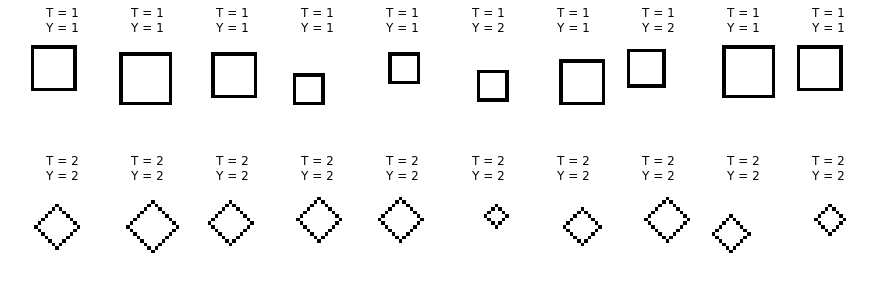

In [22]:
classes = np.unique(Ttrain)
_, Ttrain_0 = np.where(Ttrain == classes)
_, Ttest_0 = np.where(Ttest == classes)

Xtraint = torch.tensor(Xtrain)
Ttraint = torch.tensor(Ttrain_0)
Xtestt = torch.tensor(Xtest)
Ttestt = torch.tensor(Ttest_0)

Xtmean = Xtraint.mean(0)
Xtstd = Xtraint.std(0)

# Xtraint = (Xtraint - Xtmean) / Xtstd
# Xtestt = (Xtestt - Xtmean) / Xtstd
Xtraint = Xtraint
Xtestt = Xtestt

n_channels = Xtraint.shape[1]
n_outputs = len(classes)

nnet = torch.nn.Sequential()

n_units = 1
kernel_size = 5
kernel_stride = 2
nnet.add_module('conv_1', torch.nn.Conv2d(n_channels, n_units, kernel_size, kernel_stride))
nnet.add_module('relu_1', torch.nn.ReLU())
n_windows = (Xtraint.shape[2] - kernel_size) // kernel_stride + 1

if False:
    n_units_previous = n_units
    n_units = 3
    kernel_size = 3
    kernel_stride = 1
    nnet.add_module('conv_2', torch.nn.Conv2d(n_units_previous, n_units, kernel_size, kernel_stride))
    nnet.add_module('relu_2', torch.nn.ReLU())
    n_windows = (n_windows - kernel_size) // kernel_stride + 1

nnet.add_module('flatten', torch.nn.Flatten())
n_units_previous = n_units
n_units = 3
n_inputs = n_units_previous * n_windows ** 2
nnet.add_module('linear_1', torch.nn.Linear(n_inputs, n_units))
nnet.add_module('tanh', torch.nn.Tanh())

nnet.add_module('linear 2', torch.nn.Linear(n_units, n_outputs))


loss_F = torch.nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

for epoch in range(400):
    
    optimizer.zero_grad()
    
    Ytraint = nnet(Xtraint)
    
    error = loss_F(Ytraint, Ttraint)
    if epoch % 50 == 0:
        print(f'Epoch {epoch} error {error:.5f}')
        
    error.backward()
    
    optimizer.step()

Ytestt = nnet(Xtestt)
Ytest = Ytestt.detach().numpy()
Ytestclasses = classes[Ytest.argmax(axis=1)].reshape((-1, 1))
plt.figure(figsize=(15, 5))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(Xtest[i, 0, :, :], cmap=plt.cm.binary)
    plt.title(f'T = {int(Ttest[i, 0])}\nY = {int(Ytestclasses[i])}')
    plt.axis('off')
    
print(f'{np.sum(Ttest == Ytestclasses)} out of {Ttest.shape[0]} test samples correctly classified.')

In [23]:
number_of_weights(nnet)

229

In [24]:
nnet.conv_1.weight

Parameter containing:
tensor([[[[ 0.3175, -1.0126, -2.0491,  0.2195, -1.0584],
          [ 1.2623, -0.7258, -1.1719, -1.0872, -1.2446],
          [ 2.5027, -0.0032,  0.9389,  1.3074,  0.2435],
          [-0.6979, -0.1902, -0.5209, -1.6157, -0.8797],
          [ 0.2218, -1.0567, -1.7640, -1.7015, -0.6102]]]], requires_grad=True)

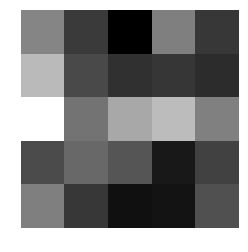

In [25]:
w = nnet.conv_1.weight.detach()
for uniti in range(w.shape[0]):
    plt.subplot(1, w.shape[0], uniti + 1)
    plt.imshow(w[uniti, 0, :, :], cmap=plt.cm.gray)
    plt.axis('off')